In [1]:
import numpy
import numpy as np
import pandas as pd
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
warnings.filterwarnings('ignore')
import pycountry
sys.path.append(os.getcwd()+'/../../cds-backend/code/')
import cds_eua3 as eua
# import numbaprocess
import copy
import glob
from numba import njit
import pandas
import glob
import pickle
import matplotlib
import matplotlib.pyplot as plt
import h5py as h5
import netCDF4 as nc
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
    
from multiprocessing import Pool
from functools  import partial

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


# CONVENTIONS on bias
- CUON: we must subtract the bias adjustment found in the adv_homog table from the raw i.e. adj = raw - bias
- RHARM and SUNY: we must subtract adjusted from raw i.e. bias= raw - adj

### Download IGRA-RHARM data from CDS / CDSTEST

In [2]:
stdplevs = [ i*100 for i in [10.0, 20.0, 30.0, 50.0, 70.0, 100.0, 150.0, 200.0, 250.0, 300.0, 400.0, 500.0, 700.0, 850.0, 925.0, 1000.0] ]


In [3]:
# Select here the date range of interest
y_min, y_max = 2009 , 2010 

# Select here the date pressure of interest
p = 10000

### Extract CUON data from CSV database

In [4]:
def read_csv(file, p, y_min, y_max, ds=''):

    """ Extract the data from the IGRA, RHARM, CUON dataframes for plotting.
        Adjustments of RHARM must be calculated by subtracting obs data RHARM-IGRA
        """
    #file = 'data_SUNY/ACM00078861.csv'
    
    #print('FILE:::' , file)
    # adapt column names
    if ds in ['RHARM', "IGRA"]:
        df = pd.read_csv(file, sep = ',')
        df['report_timestamp'] = pd.to_datetime( df['report_timestamp'] ).dt.tz_localize(None)  ### TO DO to remove the +00 from timestamps , see Cannot compare tz-naive and tz-aware datetime-like objects

        time, pressure = 'report_timestamp' , 'air_pressure'

    elif ds in ['CUON']:
        df = pd.read_csv(file, sep = '\t')
        time, pressure = 'date_time' , 'z_coordinate'

    elif ds in ['SUNY']:
        df = pd.read_csv(file, sep = '\t')
        time, pressure = 'date_time' , 'air_pressure'
             
    #print(file, p, y_min, y_max, ds, time)
    #print(df.columns)
    df[time] = pd.to_datetime(df[time])

    df = df[df[pressure]==p]
    df = df.loc[ (df[time] > pd.to_datetime(y_min)) & ((df[time] > pd.to_datetime(y_min))) ] 
    
    df.station = file.split('/')[1].replace('.csv','')
    return df

In [5]:
# test
# Read CUON data and Calculate averages 
#file = 'data_SUNY/ACM00078861.csv'
#a = get_data_from_csv(file, p, '20090101', '2010101', ds='SUNY')
#a.station

In [6]:
def get_rharm_adj(i,h,):
    """ Extract the RHARM adjustment.
        First join the dataframe along the timestamp-pressure axes, then calculated the difference between 
        the RHAR-IGRA temp. values.
        Return the RHARM dataframe with an additional column """
    
    i = i[['report_timestamp', 'air_pressure', 'air_temperature']]
    i['air_temperature_i'] = i['air_temperature']
    
    h = h [['report_timestamp','air_pressure', 'air_temperature']]
    h['air_temperature_h'] = h['air_temperature']

    d = h.merge(i, how='outer')
    d['adj'] = d.air_temperature_h - d.air_temperature_i

    return d

In [7]:
def get_night_day_diff(df, ds='IGRA', bias=''):
    
    """ Extract day and night differences from a dataframe.
        Processing slightly different for IGRA/RHARM, CUON or SUNY.
        
        Have to return two different temp_diff since for RHAR/IGRA from CDS I process separately the two dataframes
        and then calculate the adj by subtracting RHARM-CUON,
         
        while for CUON and  RHAR/IGRA crom CSV I have the adj in the same dataframe """
    
    #print(df.columns, ' ' , what)
    # name of timestamp in the different dataframes 
    dt_col = 'date_time' if ds not in ['IGRA','RHARM'] else 'report_timestamp'

    df['date'] =  pd.to_datetime(df[dt_col])
    df['hour'] = df['date'].dt.hour
    
    df = df.reset_index()

    # Must correct for days 
    
    ### print( df.head(10) )
    night_hours = [0,1,2,3 ]
    nights = list(np.where( df.hour.isin(night_hours)  )[0] )
    df.loc[nights, 'hour'] = 0
    # ---    
    following_day_night_hours = [21,22,23]
    nights = list(np.where( df.hour.isin(following_day_night_hours))[0])
    df['date'][nights] = df['date'][nights] +  pd.Timedelta(1,unit='d')
    df.loc[nights, 'hour'] = 0
    # --- 
    day_hours = [11,12,13,14] 
    day = np.where( df.hour.isin(day_hours))[0]
    df.loc[day, 'hour'] = 12
    
    df['date'] = df['date'].dt.date

    iday   = df.loc[df.hour == 12 ]
    inight = df.loc[df.hour == 0 ]

    #iday = iday.drop_duplicates(subset=['date'])
    #inight = inight.drop_duplicates(subset=['date'])

    # df['adj'] = df.air_temperature_rharm - df.air_temperature_igra 

    days_set = set(iday.date) # make a set of the first list
    days_set.intersection_update(inight.date)
    #print(len(iday.date), len(inight.date), len(days_set) )
    
    day_set = list(days_set)
    df = df.loc[df['date'].isin(days_set)]
    
    #return day_set, df 

    days_set = df.date
    #print(df)
    #print(df[df.hour==12].head(10).air_temperature_igra)
    #print(df[df.hour==0].head(10).air_temperature_igra)
    #print(  df[df.hour==12].air_temperature_igra.values - df[df.hour==0].air_temperature_igra.values)

    df = df.drop_duplicates( subset =['date','hour'])
    
    days = df[df.hour==12].date 
    
    if ds in ['IGRA','RHARM']:
      
        temp_diff_i =  df[df.hour==12].air_temperature_igra.values   - df[df.hour==0].air_temperature_igra.values
        temp_diff_h =  df[df.hour==12].air_temperature_rharm.values - df[df.hour==0].air_temperature_rharm.values
        return  days, temp_diff_i , temp_diff_h
        
    elif ds == 'SUNY':
        temp_diff_raw =  df[df.hour==12].air_temperature.values  -  df[df.hour==0].air_temperature.values
        temp_diff_adj =  df[df.hour==12].air_temperature_adj.values  -  df[df.hour==0].air_temperature_adj.values

        return days, temp_diff_raw, temp_diff_adj
        
    else:
        temp_diff =  df[df.hour==12].observation_value.values  - df[df.hour==0].observation_value.values
        if bias =='RAOBCORE':
            temp_diff_adj =  df[df.hour==12].observation_value.values - df[df.hour==12].RAOBCORE_bias_estimate.values
            temp_diff_adj = temp_diff_adj -(df[df.hour==0].observation_value.values-df[df.hour==0].RAOBCORE_bias_estimate.values)  
        elif bias== "RASE":
            temp_diff_adj =  df[df.hour==12].observation_value.values - df[df.hour==12].RASE_bias_estimate.values
            temp_diff_adj = temp_diff_adj -(df[df.hour==0].observation_value.values-df[df.hour==0].RASE_bias_estimate.values)              
        elif bias== "RICH":
            temp_diff_adj =  df[df.hour==12].observation_value.values - df[df.hour==12].RICH_bias_estimate.values
            temp_diff_adj = temp_diff_adj -(df[df.hour==0].observation_value.values-df[df.hour==0].RICH_bias_estimate.values) 
        elif bias== "RISE":
            temp_diff_adj =  df[df.hour==12].observation_value.values - df[df.hour==12].RISE_bias_estimate.values
            temp_diff_adj = temp_diff_adj -(df[df.hour==0].observation_value.values-df[df.hour==0].RISE_bias_estimate.values) 
            
        return days, temp_diff, temp_diff_adj

In [8]:
def extract_data_from_df(df, ds='CUON', bias=''):
    """ Extract and manipulate data from the original dataframes.
        Returns date times, raw temp diff, adjusted temp diff in a vector [] """
    
    if ds in ['CUON']:
        c_date, c_temp_diff, c_temp_diff_RAOBCORE = get_night_day_diff(df, ds=ds, bias=bias)
        v = [c_date, c_temp_diff, c_temp_diff_RAOBCORE]  
    elif ds in ['SUNY']:
        s_date, s_tempdiff_raw, s_tempdiff_adj = get_night_day_diff(df, ds=ds)      
        v = [s_date, s_tempdiff_raw, s_tempdiff_adj]        
    else:    
        ih_dates, temp_diff_i , temp_diff_h = get_night_day_diff(df, ds=ds)
        v  = [ih_dates, temp_diff_i , temp_diff_h] 

    return v


def filter_day_night(i,h,c,s, time = 'day'):
    # filtering hours for day and night
    
    if time == 'day':
        i = i.loc[ i['report_timestamp'].dt.hour == 12 ] 
        h = h.loc[ h['report_timestamp'].dt.hour == 12 ] 
        c = c[c['date_time'].dt.hour.isin([10,11,12,13,14]) ] 
        s = s[s['date_time'].dt.hour == 12 ]
        
    elif time == 'night':
        i = i.loc[ i['report_timestamp'].dt.hour== 0 ] 
        h = h.loc[ h['report_timestamp'].dt.hour== 0 ] 
        c = c[c['date_time'].dt.hour.isin([22,23,0,1,2]) ] 
        s = s[s['date_time'].dt.hour == 0 ]
        
    return i,h,c,s


def calculate_day_night_adjustment(data='', time='night'):
    """ Calculate adjustments """
    
    c,i,h,s = data["CUON"]['df'], data["IGRA"]['df'],  data["RHARM"]['df'], data["SUNY"]['df']
    
    ############## calculating adjustments
    i,h,c,s = filter_day_night(i,h,c,s, time=time)

    if source != 'csv':
        adj      = get_rharm_adj(i,h)
        #adj_test = get_rharm_adj( i_test,h_test)  ### this was for CDS-TEST, remove 
    else:
        adj = i
        #adj_test = i ### this was for CDS-TEST, remove 
        
    # return df ready for adjustments
    return c, s, i, adj     

In [9]:
def extract_averages(igrainv, p, date_min , date_max, ds, bias, stat_file):
        
    #             res.append(extract_averages(igrainv, p, date_min , date_max, ds, bias, s ) )

    df = read_csv(stat_file, p, y_min, y_max, ds=ds)
    stat = df.station
    a = igrainv.loc [igrainv.StationId == stat ]

    if a.empty: # case of CUON numbers, to be fixed 
        #print('No igra Id found', )
        igrastat = [ i[6:] for i in igrainv.StationId.values ]
        #print(igrastat)
        igrainv['igrastat'] = igrastat
        a = igrainv.loc [igrainv.igrastat == stat ]

    try:
        lat, lon = a.Latitude.values[0] , a.Longitude.values[0]
        #print (res , df)
        data = extract_data_from_df(df, ds=ds, bias=bias)
        dates = pd.to_datetime( data[0] )
        df = pd.DataFrame.from_dict( {'date_time': pd.to_datetime(data[0]), "raw": data[1] , 'adj':data[2]  } )
        df = df[ (df.date_time > pd.to_datetime(date_min))  & (df.date_time < pd.to_datetime(date_max)) ]

        raw_average = np.nanmean(df.raw)
        adj_average = np.nanmean(df.adj)

    except:
        lat, lon, raw_average, adj_average = 0,0, -999,-999
        
    return stat, lat, lon, raw_average, adj_average

In [10]:
def make_maps_plotly(data):
    """ Make interactive maps using PLOTLY library for interactivity """
    
    #data["SUNY"]['daynight'] = [s_date, s_tempdiff_raw, s_tempdiff_adj] ### structure of data
    
    
    p, ds = data.p, data.ds
    date_min, date_max = data.date_min, data.date_max
    bias = data.bias
    data = data.dropna(subset=['raw'])
    
    #data.raw = [float(r) for r in data.raw.values]
    #data.adj = [float(r) for r in data.adj.values]
    
    fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.5, 0.5],
    row_heights=[0.01],
    specs=[[{"type": "scattergeo", "rowspan": 1},  {"type": "scattergeo", "rowspan": 1}],
           ], 
    
    subplot_titles=("Raw","Adjusted")
    )

    fig.add_trace(go.Scattergeo(
        lon = data['lon'],
        lat = data['lat'],
        text = data['stat'],
        mode = 'markers',
        #marker_color = data['adj'],
        marker = dict(
            size = 8,
            #opacity = 0.8,
            #reversescale = True,
            #autocolorscale = False,
            #symbol = 'square',
            line = dict(
                width=1,
            ),
            colorscale = 'RdBu',
            cmin = -1,
            color = data['raw'],
            cmax = 1,
            colorbar_title="Temp Diff [K]"
        
        ),
    ),
    row=1, col=1
    )

    fig.add_trace(go.Scattergeo(
        lon = data['lon'],
        lat = data['lat'],
        text = data['stat'],
        mode = 'markers',
        #marker_color = data['adj'],
        marker = dict(
            size = 8,
            #opacity = 0.8,
            #reversescale = True,
            #autocolorscale = False,
            #symbol = 'square',
            line = dict(
                width=1,
            ),
            colorscale = 'RdBu',
            cmin = -1,
            color = data['adj'],
            cmax = 1,
            colorbar_title="Temp Diff [K]"
        
        ),
    ),
    row=1, col=2
    )

    fig.update_traces(marker=dict(size=6,
                              line=dict(width=1,
                                        color='gray'))
                     )
                      
    fig.update_layout(
            title = ds + ' ' + bias + ' Dataset - 12:00GMT-00:00GMT Temperature Difference [K] , p=' + str(p) + ' [Pa] between ' + date_min + '-' + date_max,
            height=600, width=1800,
        )
    fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=False)

    fig.show()
    
    


In [11]:
def extract_map_data(ds='', bias='', p='', date_min='', date_max='', force_extract=False, pool=True):
    """ Extract the data for a given 
        dataset: ds
        bias type: bias
        pressure: p
        minimum date: date_min
        maximum date: date_max
        
        Use pool multiprocessing or single process.
        Note: RHARM data only available between 20090101 and 20100131 for now.
        
        If data for the desired combination is available in the directory 'data_MAPS' will read it
        if not OR if force_extract=True, will read data from original csv files
        
        """
    
    if ds in ['SUNY', 'CUON']:
        directory= 'data_' + ds 
    else:
        directory = 'new_data_emanuele_27Sept2022'

    # 
    maps_dir = 'data_MAPS'
    if not os.path.isdir(maps_dir):
        os.mkdir(maps_dir)
        
    # Here I look if data for the desired combination of dates/pressure/dataset exists and if so load it
    # unless the force_extract option is selected
    
    file = maps_dir+'/'+ ds+'_'+bias+'_plevel_'+str(p)+'_'+date_min+'_'+date_max+'.csv' 
    if not force_extract and os.path.isfile(file) :
        print('Reading ::: ' , ds, ' ' , bias , ' plevel= ' , p , ', date range: ' , date_min , ' ' , date_max  )
        map_df = pd.read_csv(file, sep='\t')
        
    else:
        print('Extracting ::: ' , ds, ' ' , bias , ' plevel= ' , p , ', date range: ' , date_min , ' ' , date_max  )

        stations = glob.glob(directory+'/*')

        POOL = pool
        if POOL:
            pr = Pool(30)
            func = partial(extract_averages, igrainv, p, date_min , date_max, ds, bias)
            res = pr.map(func, stations)     

        else:      
            res = []
            for s in stations:
                res.append(extract_averages(igrainv, p, date_min , date_max, ds, bias, s ) )

        map_df = {'stat':[], 'lat':[] , 'lon':[], 'raw':[], 'adj':[] }

        for r in res:
            map_df['stat'].append(r[0])
            map_df['lat'].append(r[1])
            map_df['lon'].append(r[2])
            map_df['raw'].append(r[3])
            map_df['adj'].append(r[4])

        map_df = pd.DataFrame.from_dict(map_df)
        map_df.to_csv(file, sep='\t')
        
    
    # adding metadata
    map_df.date_min = date_min
    map_df.date_max = date_max
    map_df.ds = ds 
    map_df.p = p
    map_df.bias = bias 

    return map_df 
    

In [12]:
# Extracting data from slimmed CSV files 

In [13]:
igrainv=pd.read_fwf('igra2-station-list.txt',widths=(11,10,7,4,30,5,5,7),
                        names=('StationId','Latitude','Longitude','Elev','dummy','StationName','From','To','Nrec'))   

# common parameters
date_min , date_max =  '20090101' , '20101231'
plevel = 10000
POOL = True
force = False

In [14]:
map_df_RHARM = extract_map_data(ds='RHARM', bias='', p=plevel, date_min=date_min, date_max=date_max, pool=False)

Reading :::  RHARM     plevel=  10000 , date range:  20090101   20101231


In [15]:
map_df_RAOBCORE = extract_map_data(ds='CUON', bias='RAOBCORE', p=plevel, date_min=date_min, date_max='20100101', pool=POOL)
#map_df_RAOBCORE_2011 = extract_map_data(ds='CUON', bias='RAOBCORE', p=plevel, date_min=date_min, date_max='20101231', pool=POOL)

Reading :::  CUON   RAOBCORE  plevel=  10000 , date range:  20090101   20100101


In [16]:
map_df_RASE = extract_map_data(ds='CUON', bias='RASE', p=plevel, date_min=date_min, date_max=date_max, pool=POOL)

Reading :::  CUON   RASE  plevel=  10000 , date range:  20090101   20101231


In [17]:
map_df_RICH = extract_map_data(ds='CUON', bias='RICH', p=plevel, date_min=date_min, date_max=date_max, pool=POOL)

Reading :::  CUON   RICH  plevel=  10000 , date range:  20090101   20101231


In [18]:
map_df_RISE = extract_map_data(ds='CUON', bias='RISE', p=plevel, date_min=date_min, date_max=date_max, pool=POOL)

Reading :::  CUON   RISE  plevel=  10000 , date range:  20090101   20101231


In [19]:
map_df_SUNY = extract_map_data(ds='SUNY', bias='', p=plevel, date_min=date_min, date_max=date_max, pool=POOL)

Reading :::  SUNY     plevel=  10000 , date range:  20090101   20101231


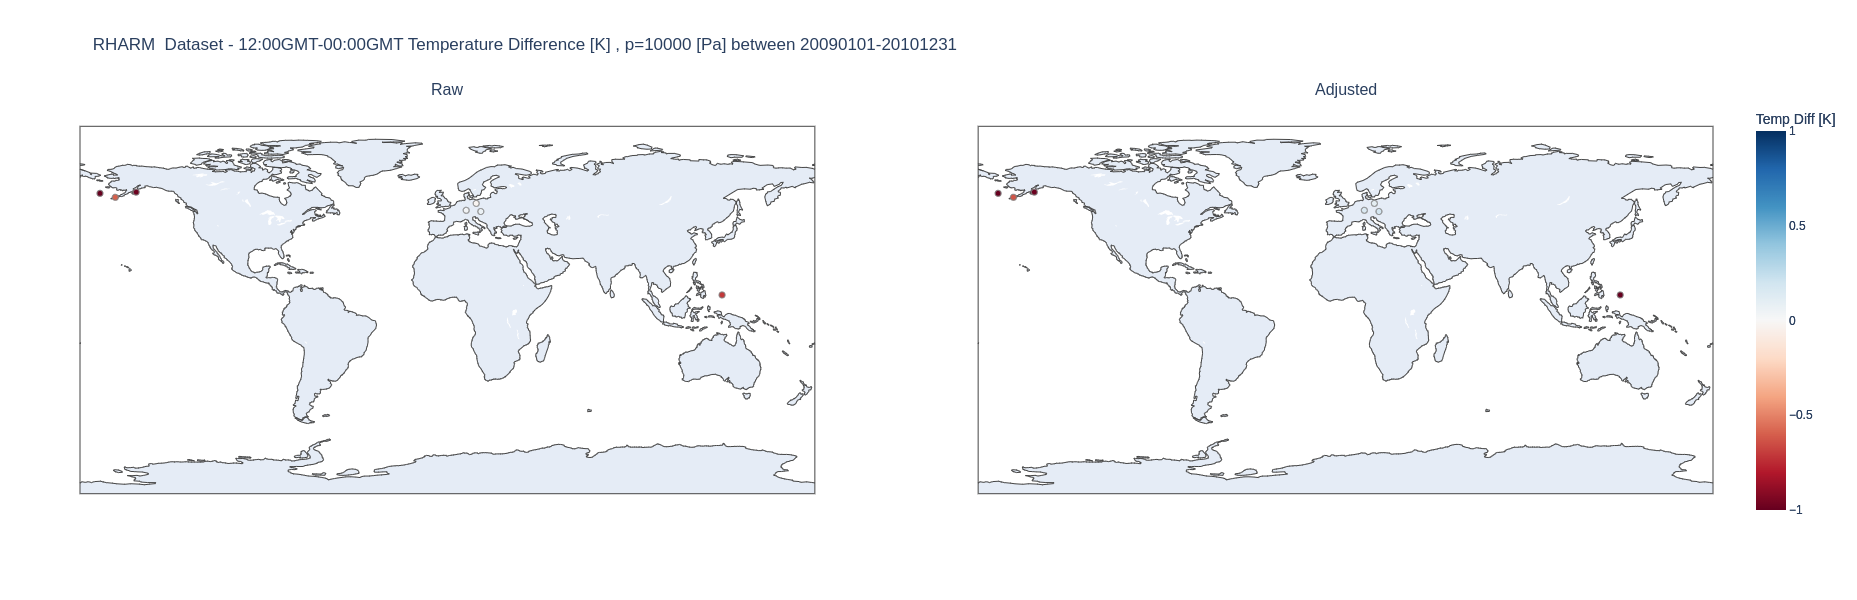

In [20]:
f = make_maps_plotly(map_df_RHARM)

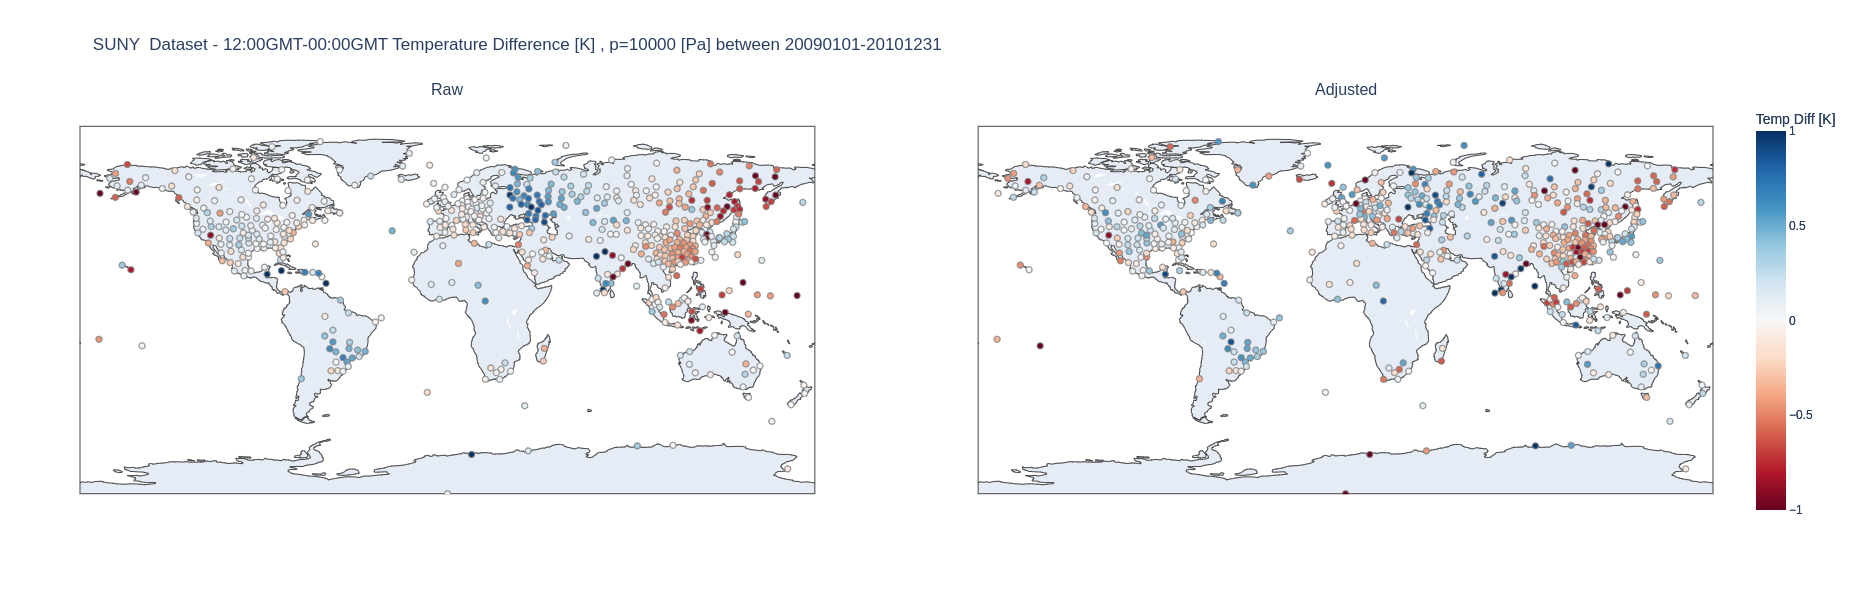

In [21]:
f = make_maps_plotly(map_df_SUNY)

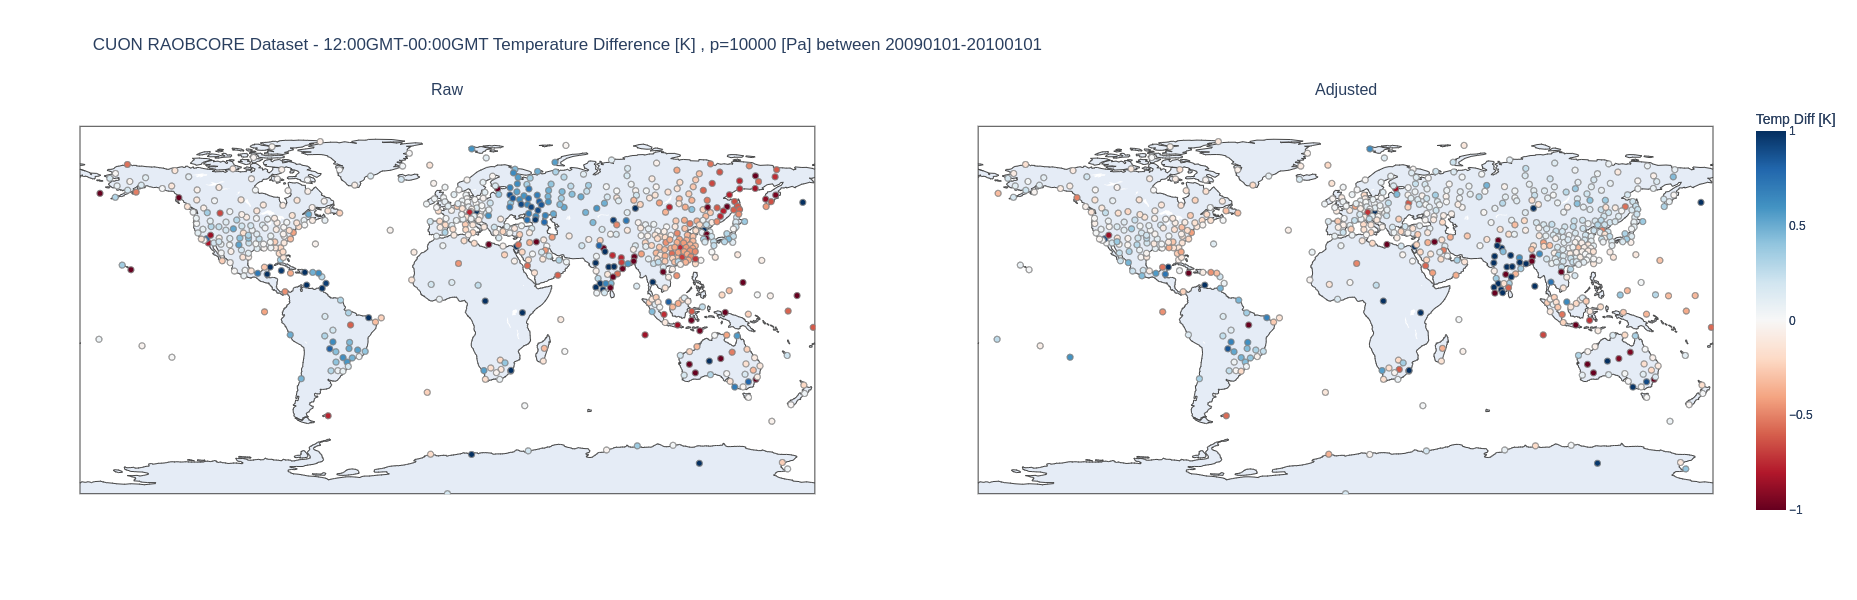

In [22]:
f = make_maps_plotly(map_df_RAOBCORE)

NameError: name 'map_df_RAOBCORE_2011' is not defined

In [ ]:
f = make_maps_plotly(map_df_RICH)

In [ ]:
f = make_maps_plotly(map_df_RASE)

In [ ]:
f = make_maps_plotly(map_df_RISE)

In [ ]:
#map_df_RICH.head(10)

In [ ]:
#map_df_RASE.head(10)

In [ ]:
#map_df_RAOBCORE.head(10)

![pic](pic.png)

In [ ]:
def make_maps_static(data_SUNY, data_RAOBCORE, data_RICH, data_RASE, data_RHARM):
    
    from matplotlib.gridspec import GridSpec
    import cartopy.crs as ccrs
    crs = ccrs.PlateCarree()
    cm = plt.cm.get_cmap('RdYlBu')
    
    # parameters from the dataframe
    p, min_date, max_date = data_SUNY.p, data_SUNY.date_min, data_SUNY.date_max 
        
    # Limits for color bar
    vmin, vmax = -1, 1 
    
    #fig = plt.figure(figsize=(5,50))
    #fig = plt.figure()
    fs = 20
    gs = GridSpec(4,2, wspace=0.1, hspace=0.000001)
    fig = plt.figure(figsize=(33,37))
    
    title = '12:00GMT-00:00GMT Temperature Difference [K] , p=' + str(p) + ' [Pa] between ' + min_date + '-' + max_date 
    fig.suptitle(title, fontsize = 25, y=0.9)

        
    def subplotter(df, title='', data = '', k = ''):
        import matplotlib.ticker as mticker
        from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

        """ Plot each subplot of the gridspec """
        # SUNY raw
        ax = plt.subplot(gs[k],projection=crs)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.coastlines()
        plt.scatter( df['lon'] , df['lat'],
             c=df[data], 
             marker='o',
             linewidths=0.4,
             edgecolors='gray',
             transform=ccrs.PlateCarree(),
             vmin=vmin, vmax=vmax, cmap=cm) 
        plt.colorbar(fraction=0.026, pad=0.02)

        ax.set_title(title, fontsize=fs, y=1.03)
        ax.set_ylim([-90,90])
        
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1.1, color='blue', alpha=0.2, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right = False
        gl.xlabels_bottom = True
        
        gl.xlines = True
        gl.xlocator = mticker.FixedLocator([-180, -120, -60 , 0, 60, 120, 180])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 11, 'color': 'blue'}
        gl.ylabel_style = {'size': 11, 'color': 'blue'}
        #gl.xlabel_style = {'color': 'gray', 'weight': 'bold'}


        
    subplotter(data_SUNY, title='SUNY Raw', data = 'raw', k = 0)
    subplotter(data_SUNY, title='SUNY Homog.', data = 'adj', k = 1)
    subplotter(data_RAOBCORE, title='CUON Raw', data = 'raw', k = 2)
    subplotter(data_RAOBCORE, title='CUON RAOBCORE', data = 'adj', k = 3)
    subplotter(data_RICH, title='CUON RICH', data = 'adj', k = 4)
    subplotter(data_RASE, title='CUON RASE', data = 'adj', k = 5)
    subplotter(data_RHARM, title='IGRA', data = 'raw', k = 6)
    subplotter(data_RHARM, title='RHARM', data = 'adj', k = 7)
    

In [ ]:
make_maps_static(map_df_SUNY, map_df_RAOBCORE, map_df_RICH, map_df_RASE, map_df_RHARM)